In [38]:
import numpy as np
import scipy as sp
from sklearn.svm import SVC

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
%matplotlib inline

Optimizing hyperparameters for the MINIST Dataset

http://yann.lecun.com/exdb/mnist/

In [39]:
import cPickle, gzip, numpy

# Load the dataset
f = gzip.open('mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = cPickle.load(f)
f.close()

In [40]:
# Our objective/black box function
def score_svm(g):
    clf = SVC(kernel="rbf", gamma=2**g)
    clf.fit(train_set[0][:1000], train_set[1][:1000])
    s = clf.score(valid_set[0][:500], valid_set[1][:500])
    return np.log((s / (1 - s)))

# How smooth is our function?
def kernel(a, b):
    """ Matern 5/2 Corvariance"""
    kernelParameter = 1
    sqdist = (1/kernelParameter) * np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return (1 + np.sqrt(5 * sqdist) + (5/3) * sqdist) * np.exp(-np.sqrt(5 * sqdist))


N = 1    # number of training points.
n = 1000        # number of test points.
s = 0.00005    # noise variance.


# Perform 2 inital evaulations of our function
X = np.random.uniform(-20, 20, size=(N,1))
y_unnorm = [score_svm(x) for x in X]
y = y_unnorm - np.mean(y_unnorm)
K = kernel(X, X)
L = np.linalg.cholesky(K + s*np.eye(N))

# points we're going to make predictions at.
Xtest = np.linspace(-20, 20, n).reshape(-1,1)

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, Xtest))
mu = np.dot(Lk.T, np.linalg.solve(L, y))

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest)
s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
s = np.sqrt(s2)

Note that the above takes like 10 minutes per point to calculate (for the full SVM), this is one reason we want an optimization procedure which minimizes the number of steps to take

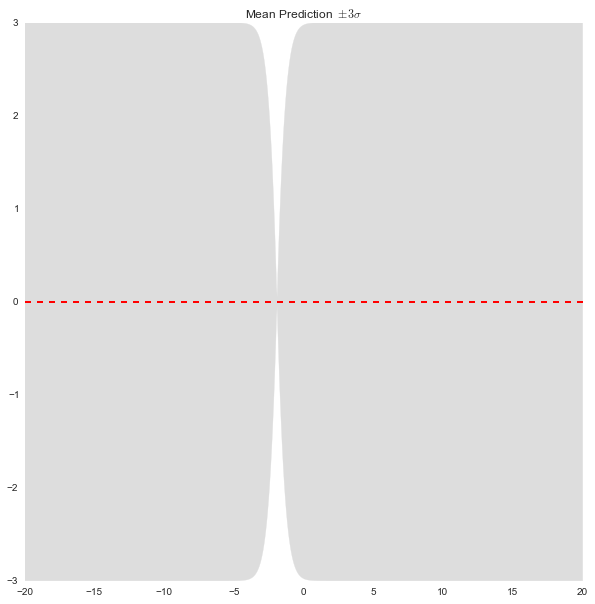

In [41]:
# draw samples from the posterior at our test points.
plt.figure(1, figsize=(10,10))
plt.clf()
plt.plot(X, y, 'r+', ms=20)
plt.gca().fill_between(Xtest.flat, mu-3*s, mu+3*s, color="#dddddd")
plt.plot(Xtest, mu, 'r--', lw=2)
plt.savefig("test.png")
plt.title("Mean Prediction $\pm 3\sigma$")

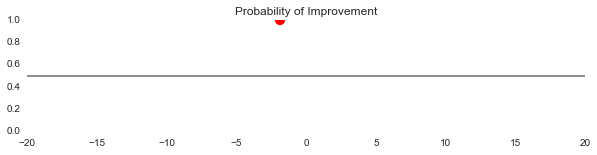

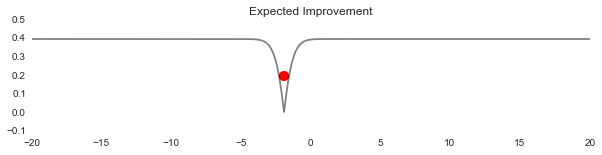

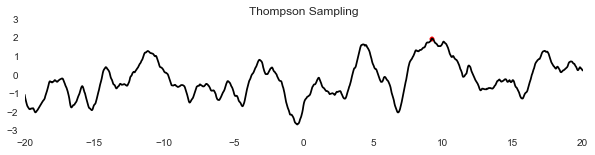

In [42]:
def EI(mu, s, best):
    Z = (mu - best - 1e-20) / s
    return ((mu - best - 1e-20) * sp.stats.norm.cdf(Z)) + (s * sp.stats.norm.pdf(Z))

plt.figure(2, figsize=(10,2))
plt.clf()
plt.plot(Xtest, sp.stats.norm.cdf((mu - max(y) - 1e-10)/s), color="black", alpha=0.5)
plt.scatter(X,[1 for i in xrange(N)], color="red", s=100)
plt.ylim(0, 1)
plt.xlim(-20, 20)
plt.title('Probability of Improvement')
plt.show()

plt.figure(3, figsize=(10,2))
plt.clf()
plt.plot(Xtest, EI(mu, s, max(y)), color="black", alpha=0.5)
plt.scatter(X,[0.2 for i in xrange(N)], color="red", s=100)
plt.xlim(-20, 20)
plt.title('Expected Improvement')
plt.show()

L = np.linalg.cholesky(K_ + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,1)))
plt.figure(4, figsize=(10,2))
plt.clf()
plt.plot(Xtest, f_post, color="black", alpha=1)
plt.scatter(Xtest[np.argmax(f_post)], max(f_post),alpha=1, s=20, color="red")
plt.xlim(-20, 20)
plt.title('Thompson Sampling')
plt.show()

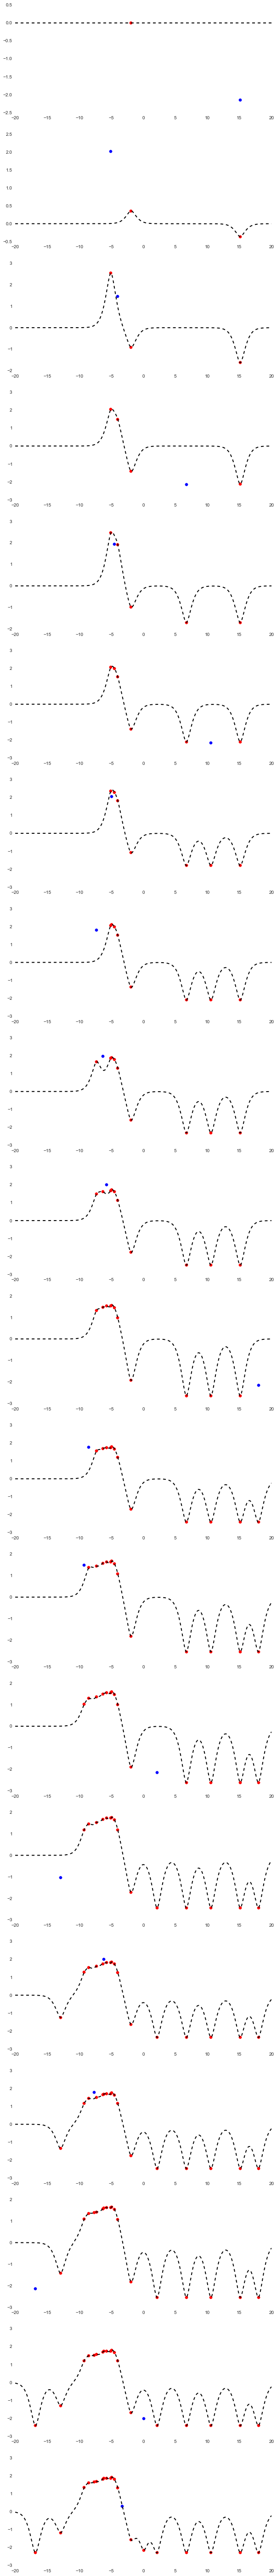

In [43]:
best = [X[np.argmax(y)][0], y[np.argmax(y)]]
max_iterations = 20
iteration = 0
fig, ax = plt.subplots(20, 1)
fig.set_size_inches(10, 100)
Current = [y[np.argmax(y)].tolist()]
while (iteration < max_iterations):
    K = kernel(X, X)
    L = np.linalg.cholesky(K + 1e-6*np.eye(N))

    # points we're going to make predictions at.
    Xtest = np.linspace(-20, 20, n).reshape(-1,1)

    # compute the mean at our test points.
    Lk = np.linalg.solve(L, kernel(X, Xtest))
    mu = np.dot(Lk.T, np.linalg.solve(L, y))

    # compute the variance at our test points.
    K_ = kernel(Xtest, Xtest)
    s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
    s = np.sqrt(s2)
    
    # Sample From Posterior - Take Max
    L = np.linalg.cholesky(K_ + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
    f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,1)))
    
    
    #Create Plot for Animation
    #ax[iteration].plot(Xtest, mu-3*s, color="black", alpha=0.4)
    #ax[iteration].plot(Xtest, mu+3*s, color="black", alpha=0.4)
    ax[iteration].scatter(X, y, s=40, color="red", alpha=1)
    ax[iteration].plot(Xtest, mu, '--', lw=2, color="black", alpha=1)
    ax[iteration].set_xlim(-20, 20)
    
    newX = Xtest[np.argmax(f_post)]
    
    #Calculate y value
    newY = score_svm(newX)
    ax[iteration].scatter(newX, newY, s=40, color="blue")
    #Increment N and add new values to data
    N += 1
    X = np.append(X, newX)
    X.shape = (N, 1)
    y_unnorm = np.append(y_unnorm, newY)
    y_unnorm.shape = (N, 1)
    y = y_unnorm - np.mean(y_unnorm)
    
    #If better, than replace
    best = [X[np.argmax(y)][0], y[np.argmax(y)]]
    Current.append(y[np.argmax(y)])
    iteration += 1
plt.show()

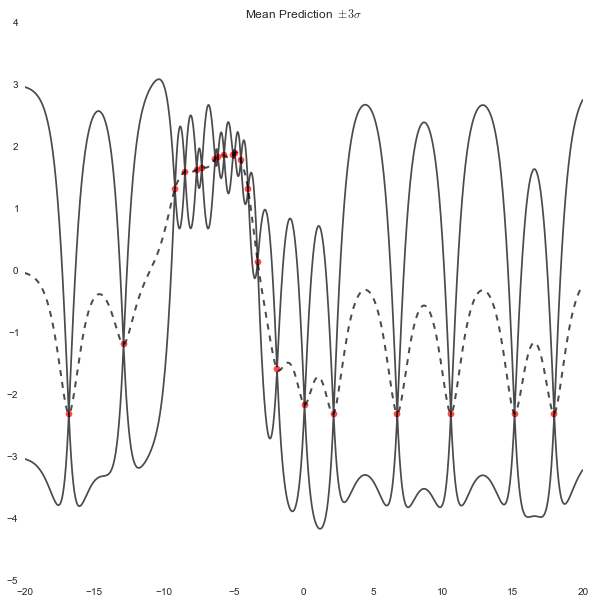

In [45]:
K = kernel(X, X)
L = np.linalg.cholesky(K + 1e-6*np.eye(N))

# points we're going to make predictions at.
Xtest = np.linspace(-20, 20, n).reshape(-1,1)

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, Xtest))
mu = np.dot(Lk.T, np.linalg.solve(L, y))

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest)
s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
s = np.sqrt(s2)
s.shape = (n, 1)
# draw samples from the posterior at our test points.
plt.figure(1, figsize=(10,10))
plt.clf()
plt.plot(Xtest, mu-3*s, color="black", alpha=0.7)
plt.plot(Xtest, mu+3*s, color="black", alpha=0.7)
plt.scatter(X, y, s=40, color="red", alpha=0.7)
plt.plot(Xtest, mu, '--', lw=2, color="black", alpha=0.7)
plt.xlim(-20, 20)
plt.title("Mean Prediction $\pm 3\sigma$")
plt.show()

In [30]:
s.shape

(1000, 1)